In [71]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
from scipy import stats
from parameters import *
from static import *
from data_frame import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
data = data_frame('../data/GSPC.csv', reference_date, current_date, moveback_date)
data.reference_date
data.df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Noramlized_Close,Diff,Normalized_Diff
Date,,,,,,,,,,
2020-07-16,2020-07-16,3208.360107,3220.389893,3198.590088,3215.570068,3215.570068,3961230000,1.347609,-10.989991,-0.004606
2020-07-17,2020-07-17,3224.209961,3233.520020,3205.649902,3224.729980,3224.729980,3993830000,1.351448,9.159912,0.003839
2020-07-20,2020-07-20,3224.290039,3258.610107,3215.159912,3251.840088,3251.840088,3971200000,1.362809,27.110108,0.011362
2020-07-21,2020-07-21,3268.520020,3277.290039,3247.770020,3257.300049,3257.300049,4547960000,1.365098,5.459961,0.002288
2020-07-22,2020-07-22,3254.860107,3270.770020,3253.100098,3263.790039,3263.790039,1378570371,1.367817,6.489990,0.002720


In [73]:
filepaths

['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv']

# Data Visualization

### Baseline

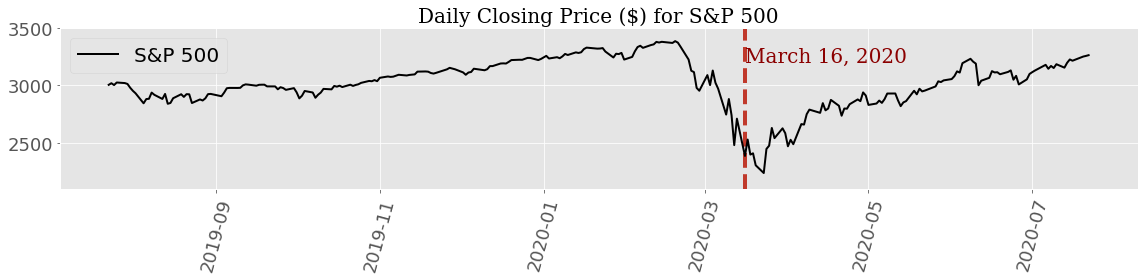

In [74]:
fig, ax = plt.subplots(figsize=(16, 4))
data = data_assessment('../data/GSPC.csv', reference_date, current_date, moveback_date)
ax.plot(data.df.index, data.df['Close'], color='k', label='S&P 500', linewidth=2)
ax.legend(loc='best', prop={'size': 20});
ax.set_title('Daily Closing Price ($) for S&P 500', fontdict=font, color='k');
ax.vlines(data.reference_date, 2100, 3500, colors='#C0392B', linestyles='dashed', linewidth=4)

ax.xaxis.set_tick_params(rotation=75)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.text(data.reference_date, 3200, r'March 16, 2020', fontdict=font);
ax.set_ylim(2100, 3500)
fig.tight_layout()
plt.savefig('../figures/baseline.png')


### Test Date

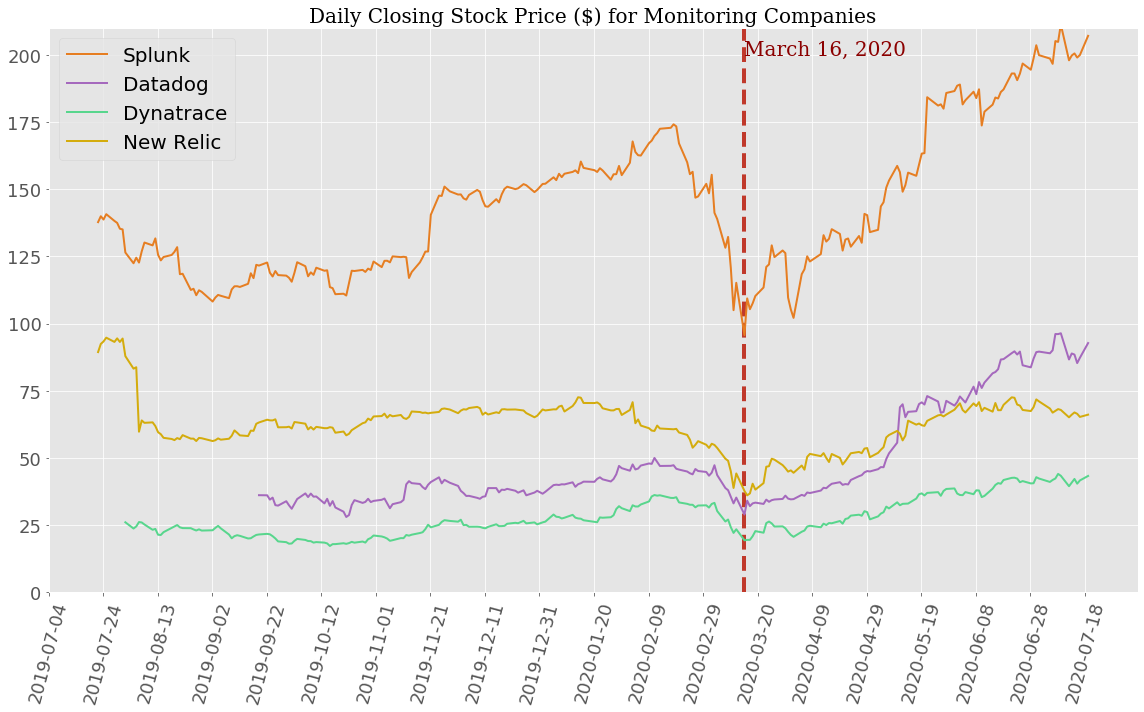

In [75]:
fig, ax = plt.subplots(figsize=(16, 10))

for filepath,color in zip(filepaths, colors):
    data = data_assessment(filepath, reference_date, current_date, moveback_date)
    ax.plot(data.df.index, data.df['Close'], color=color, label=refer[filepath], linewidth=2)

ax.vlines(data.reference_date, 0, 210, colors='#C0392B', linestyles='dashed', linewidth=4)
ax.legend(loc='best', prop={'size': 20});
ax.set_title('Daily Closing Stock Price ($) for Monitoring Companies', fontdict=font, color='k');
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 20));
ax.xaxis.set_tick_params(rotation=75)
fig.tight_layout()
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.text(data.reference_date, 200, r'March 16, 2020', fontdict=font);
ax.set_ylim(0, 210)
plt.savefig('../figures/comparison.png')

# Test Statistics
* Take difference shift(-1)
* Take 120 difference points after covid and 120 before covid
* Compute {mean, stardard deviation} of the before and after data
* Plot normal curves and run a p test

In [76]:
before_after_dict = dict()
statistics = dict()

for filepath in filepaths:
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after

    before_after_dict[refer[filepath]] = {'before': before['Diff'],'after': after['Diff']}
    statistics[refer[filepath]] = \
         {
             'before': 
             {
              'mean': round(before['Diff'].mean(),3), 
              'std':  round(before['Diff'].std(), 3), 
              'se':   round(before['Diff'].sem(), 3)
             },
              'after': 
             {
              'mean': round(after['Diff'].mean(), 3), 
              'std':  round(after['Diff'].std(), 3), 
              'se':   round(after['Diff'].sem(), 3)
              }
        }
    

In [77]:
pd.DataFrame(statistics)

,Splunk,Datadog,Dynatrace,New Relic
before,"{'mean': -0.228, 'std': 4.612, 'se': 0.45}","{'mean': -0.039, 'std': 1.699, 'se': 0.166}","{'mean': 0.008, 'std': 1.101, 'se': 0.107}","{'mean': -0.222, 'std': 1.781, 'se': 0.174}"
after,"{'mean': 1.28, 'std': 5.582, 'se': 0.598}","{'mean': 0.733, 'std': 2.727, 'se': 0.292}","{'mean': 0.275, 'std': 1.263, 'se': 0.135}","{'mean': 0.326, 'std': 1.983, 'se': 0.213}"



|           |               |     Splunk    |     Datadog   |   Dynatrace   |   New Relic  | 
|-----------|:-------------:|:-------------:|:-------------:|:-------------:|--------------|
|Before/On  | Mean          |  -0.228    |  -0.039    |   0.008   |  -0.222   |
|3/16/20    | Std. Dev.     |   4.612    |   1.699    |    1.101   |   1.781   |
|           | Std. Error    |0.45|0.166|0.107|0.174|
|After      | Mean          |1.28|0.733|0.275|0.326|
|3/16/20    | Std. Dev.     |5.582|2.727|1.263|1.983|
|           | Std. Error    |0.598|0.292|0.135|0.213

In [78]:
statistics['Splunk']['before']['mean']

-0.228

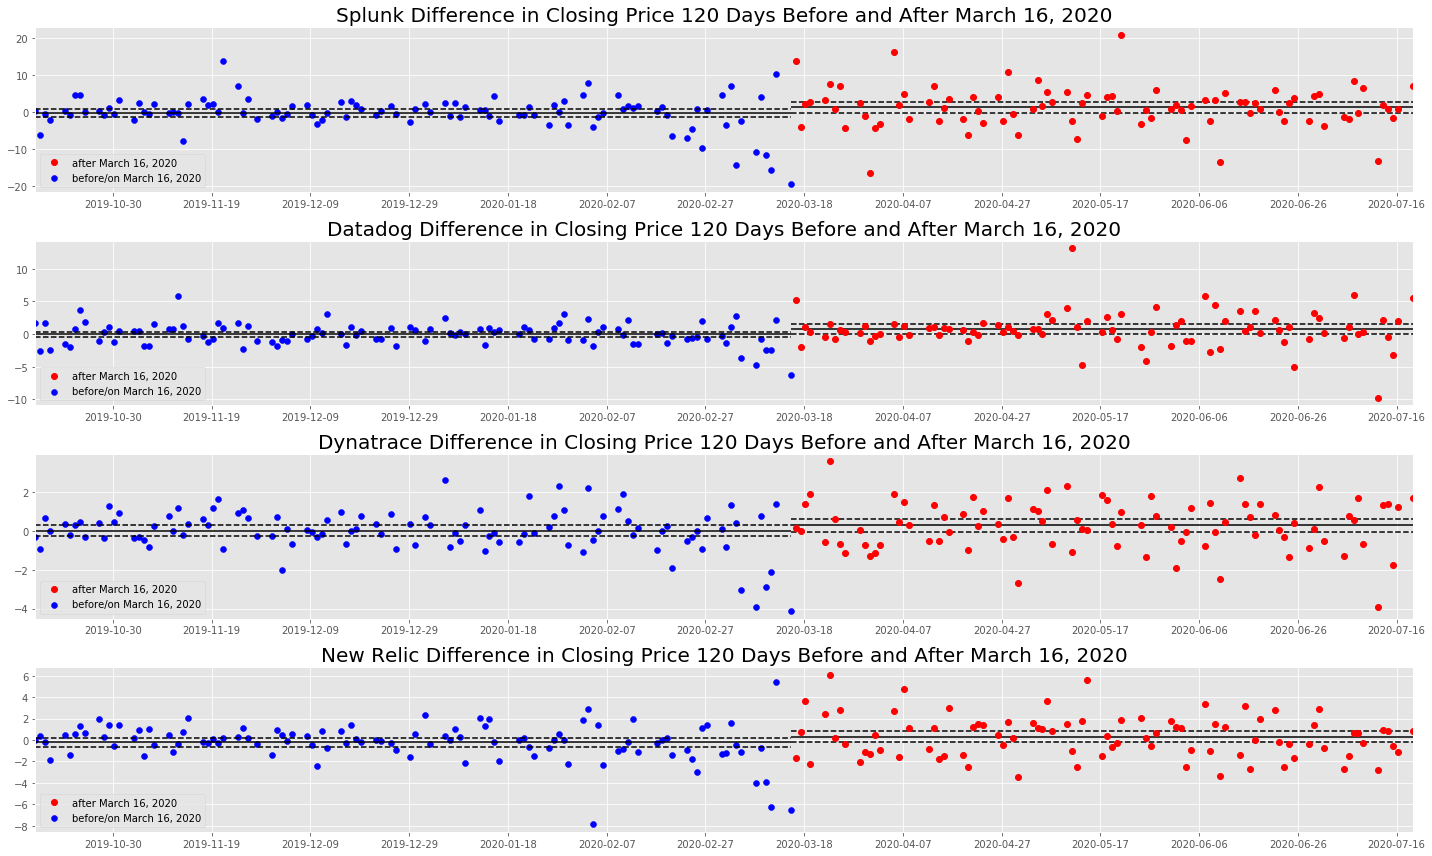

In [79]:
fig, axs = plt.subplots(4, 1, figsize=(20, 12))

filepaths = list(['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv'])
for filepath, ax  in zip(filepaths, axs):
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after
    ax.scatter(before.index, before["Diff"], color='b', label='before/on March 16, 2020')
    ax.hlines(statistics[refer[filepath]]['before']['mean'], data.moveback_date, data.reference_date, colors='k', linestyles='solid')
    ax.hlines(statistics[refer[filepath]]['before']['mean'] + 2.576* statistics[refer[filepath]]['before']['se'], data.moveback_date, data.reference_date, colors='k', linestyles='dashed')
    ax.hlines(statistics[refer[filepath]]['before']['mean'] - 2.576* statistics[refer[filepath]]['before']['se'], data.moveback_date, data.reference_date, colors='k', linestyles='dashed')
    ax.plot(after.index, after["Diff"], 'o', color='r', label='after March 16, 2020')
    ax.hlines(statistics[refer[filepath]]['after']['mean'], data.reference_date, data.current_date, colors='k', linestyles='solid')
    ax.hlines(statistics[refer[filepath]]['after']['mean'] + 2.576 * statistics[refer[filepath]]['after']['se'], data.reference_date, data.current_date, colors='k', linestyles='dashed')
    ax.hlines(statistics[refer[filepath]]['after']['mean'] - 2.576 * statistics[refer[filepath]]['after']['se'], data.reference_date, data.current_date, colors='k', linestyles='dashed')
#     ax.vlines(data.reference_date, np.min(data.df['Diff'])-1, np.max(data.df['Diff'])+1, colors='#C0392B', linestyles='dashed', linewidth=4)
    
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 20));
    ax.set_title(refer[filepath] + ' Difference in Closing Price 120 Days Before and After March 16, 2020', fontsize=20);
    ax.set_xlim((data.moveback_date, data.current_date))
    ax.legend(loc='lower left')
    
    
fig.tight_layout();
# plt.savefig('../figures/before_after_diff_distribution.png')

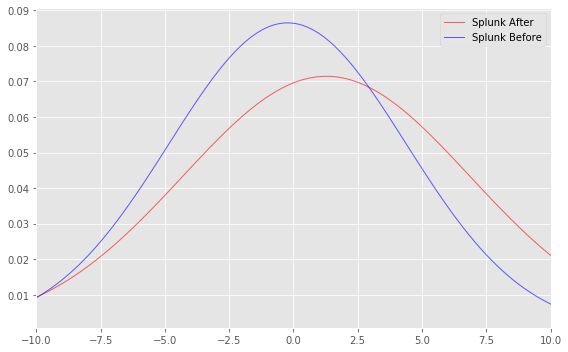

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

x = np.linspace(stats.norm.ppf(0.01, statistics['Splunk']['after']['mean'], statistics['Splunk']['after']['std']), stats.norm.ppf(0.99, statistics['Splunk']['after']['mean'], statistics['Splunk']['after']['std']), 100)
ax.plot(x, stats.norm.pdf(x, statistics['Splunk']['after']['mean'],  statistics['Splunk']['after']['std']), 'r-', lw=1, alpha=0.6, label='Splunk After')
x = np.linspace(stats.norm.ppf(0.01, statistics['Splunk']['before']['mean'], statistics['Splunk']['before']['std']), stats.norm.ppf(0.99, statistics['Splunk']['before']['mean'], statistics['Splunk']['before']['std']), 100)
ax.plot(x, stats.norm.pdf(x, statistics['Splunk']['before']['mean'],  statistics['Splunk']['before']['std']), 'b-', lw=1, alpha=0.6, label='Splunk Before')
ax.set_xlim((-10, 10))
ax.legend()

## Plot distributions before and after March 16, 2020

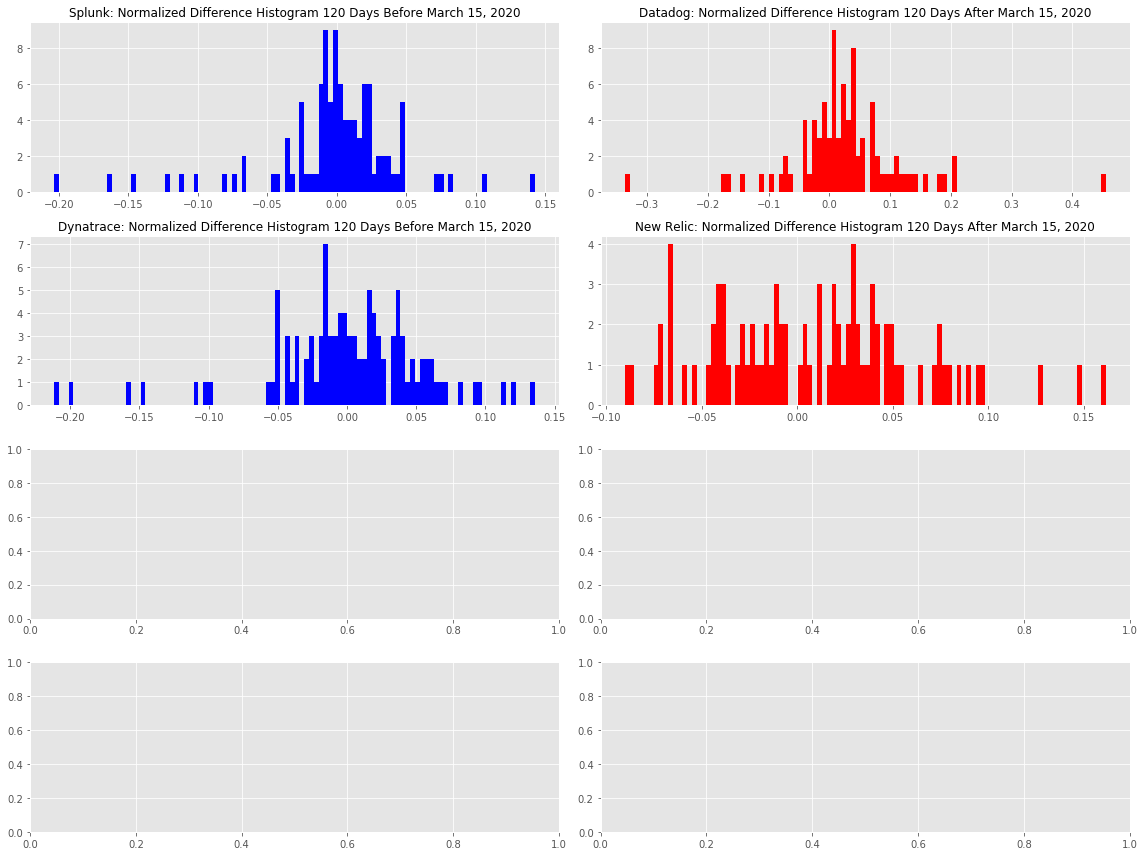

In [81]:
fig, axs = plt.subplots(4, 2, figsize=(16, 12))
plots = axs.flatten()
for filepath, ax, c  in zip(filepaths, axs.flatten(), np.arange(8)):
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after
    if c % 2:
        ax.hist(after["Normalized_Diff"], bins=100, color='r')
        ax.set_title(refer[filepath] + ': Normalized Difference Histogram 120 Days After March 15, 2020', fontsize=12)
    else:
        ax.hist(before["Normalized_Diff"], bins=100, color='b')
        ax.set_title(refer[filepath] + ': Normalized Difference Histogram 120 Days Before March 15, 2020', fontsize=12)
        
fig.tight_layout();
#plt.savefig('../figures/before_after_Histogram_Normalized_Diff.png')

In [82]:
def cdf(value, array):
    return (array<value).sum()/len(array)

vcdf = np.vectorize(cdf, excluded = ['array'])

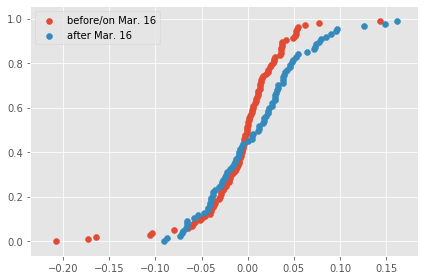

In [83]:
cdf1 = vcdf(value = before["Normalized_Diff"], array = before["Normalized_Diff"])
cdf2 = vcdf(value = after["Normalized_Diff"], array = after["Normalized_Diff"])
plt.scatter(before["Normalized_Diff"], cdf1, label='before/on Mar. 16')
plt.scatter(after["Normalized_Diff"], cdf2, label='after Mar. 16')
plt.legend()

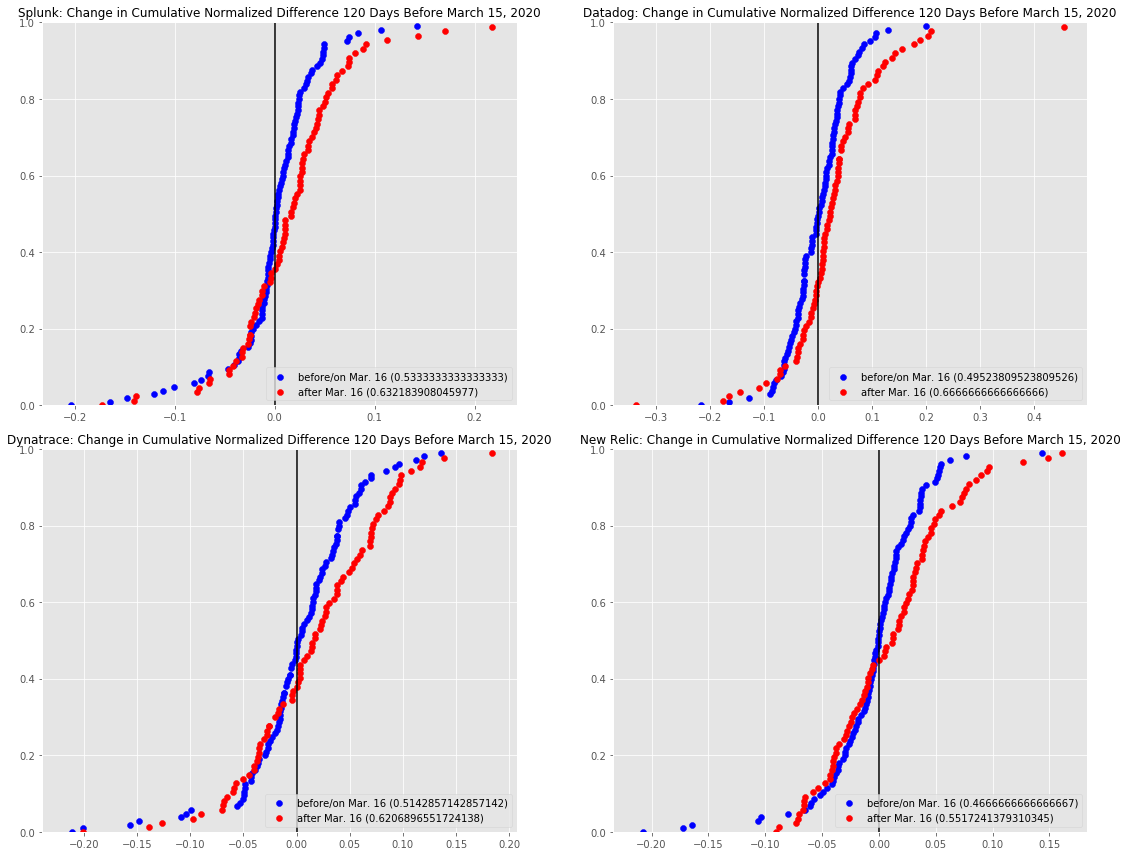

In [103]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plots = axs.flatten()
for filepath, ax, c  in zip(filepaths, axs.flatten(), np.arange(8)):
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after
    cdf1 = vcdf(value = before["Normalized_Diff"], array = before["Normalized_Diff"])
    cdf2 = vcdf(value = after["Normalized_Diff"], array = after["Normalized_Diff"])
    before_count = before[before["Normalized_Diff"]>0]['Normalized_Diff'].count() / before['Normalized_Diff'].count()
    after_count = after[after["Normalized_Diff"]>0]['Normalized_Diff'].count() / after['Normalized_Diff'].count()
    ax.scatter(before["Normalized_Diff"], cdf1, label=f'before/on Mar. 16 ({before_count})', color='b')
    ax.scatter(after["Normalized_Diff"], cdf2, label=f'after Mar. 16 ({after_count})', color='r')
    ax.set_title(refer[filepath] + ': Change in Cumulative Normalized Difference 120 Days Before March 15, 2020', fontsize=12)
    ax.vlines(0.0, 0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.legend(loc='lower right')
        
fig.tight_layout();
fig.savefig('../figures/cumul.png')

In [85]:
filepaths

['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv']

## T-test on before and after data

In [172]:
hyp_test = dict()
for filepath, ax  in zip(filepaths, axs):
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before['Diff'], data.after['Diff']
    stat, p_val = stats.ttest_ind(before, after, axis=0, equal_var=False, nan_policy='omit')
    
    hyp_test[refer[filepath]] = {'t_stat': stat, 'p_val': p_val}

pd.DataFrame(hyp_test)

,Splunk,Datadog,Dynatrace,New Relic
t_stat,-2.014599,-2.298923,-1.544077,-1.998822
p_val,0.045554,0.023007,0.124407,0.047177



|               |     Splunk    |     Datadog   |   Dynatrace   |   New Relic  | 
| ------------- |:-------------:|:-------------:|:-------------:|--------------|
| t_stat        |  -2.014599    |  -2.298923    |   -1.544077   |  -1.998822   |
| p_value       |   0.045554    |   0.023007    |    0.124407   |   0.047177   |

In [100]:
after[after["Normalized_Diff"]<0]['Normalized_Diff'].count()

39